In [4]:
import pandas as pd
import numpy as np 

import sys
sys.path.append('../../Function/')
import function

from keras.layers import Dense, Dropout
from keras.models import Sequential


In [5]:
df = pd.read_excel('../../../site_info_ver_4_lite.xlsx')

remove pollution site Successfully
model on site Hermon Stream (Banias)
Focus on  Israelis
Add Last year visitors Successfully
shape of dataset (1858, 21)
features : Index(['Date', 'is_weekend', 'operations', 'is_jewish_holiday',
       'is_muslims_holiday', 'Temperature', 'is_HeatWave', 'Beer-Sheva_pm10',
       'Haifa_pm2.5', 'Beer-Sheva_pm2.5', 'Jerusalem_nox', 'Ashkelon_nox',
       'Beer-Sheva_nox', 'Jerusalem_so2', 'Ashkelon_so2', 'Beer-Sheva_so2',
       'day', 'month', 'year', 'Last_year_visitors', 'Israelis_Count'],
      dtype='object')


,Date,is_weekend,operations,is_jewish_holiday,is_muslims_holiday,Temperature,is_HeatWave,Beer-Sheva_pm10,Haifa_pm2.5,Beer-Sheva_pm2.5,...,Ashkelon_nox,Beer-Sheva_nox,Jerusalem_so2,Ashkelon_so2,Beer-Sheva_so2,day,month,year,Last_year_visitors,Israelis_Count
0,2016-01-01,1,0,0,0,11.4,0,4.9,26.2,2.5,...,3.8,9.7,0.1,1.2,0.9,1,1,2016,383.0,71


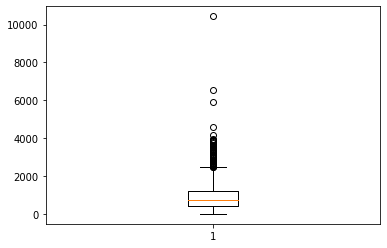

In [14]:
dataset = df.copy()
sites = dataset.Site_Name.unique()
site_name = sites[5]
target = 'Israelis_Count'
target_title = 'Israelis'
dataset = dataset.loc[dataset.Site_Name==site_name]
dataset = dataset.drop(['Total','Tourists_Count'],axis=1)
dataset = function.remove_pollution_site(dataset)
dataset = dataset.drop(dataset.filter(regex='exceeded').columns, axis=1)
dataset = dataset.drop(dataset.filter(regex='Season').columns, axis=1)

print('model on site',site_name)
print('Focus on ',target_title)

dataset = function.remove_outliers(dataset, target)
dataset = function.remove_unique_one(dataset)
dataset = function.remove_high_corr(dataset, target,0.4)
dataset = function.split_date(dataset)
dataset = function.last_year_entries_info(dataset,target)

print('shape of dataset',dataset.shape)
print('features :',dataset.columns)

dataset.head(1)

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = dataset.drop(target,axis=1)
y = dataset[target]
# X.drop(['Date','Tel_Aviv-Yafo_nox_exceeded','Season_spring','Season_autumn','Season_summer','Season_winter','Jerusalem_nox_exceeded'],axis=1,inplace=True)
X.drop(['Date'],axis=1,inplace=True)
# X = X.drop(X.filter(regex='exceeded').columns, axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=312148513)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train)
X_test_scaled = X_test_scaler.fit_transform(X_test)

y_train_scaled = np.log(y_train+0.001)
y_test_scaled = np.log(y_test+0.001)



In [16]:
from sklearn.linear_model import LinearRegression

mlr = LinearRegression()
mlr.fit(X_train_scaled,y_train_scaled)

prediction =np.exp(mlr.predict(X_test_scaled))

res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values
    },
    index=y_test.index
)

print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

coef = sorted( list(zip(np.round(mlr.coef_,3).T,X_train.columns)))
coef

rmse 523.4434937182957
std 554.252981569447


[(-0.62, 'Beer-Sheva_pm10'),
 (-0.577, 'month'),
 (-0.296, 'Ashkelon_nox'),
 (-0.275, 'Beer-Sheva_pm2.5'),
 (-0.211, 'operations'),
 (-0.112, 'Ashkelon_so2'),
 (0.111, 'Jerusalem_nox'),
 (0.116, 'Beer-Sheva_so2'),
 (0.171, 'Jerusalem_so2'),
 (0.178, 'is_muslims_holiday'),
 (0.205, 'is_HeatWave'),
 (0.22, 'year'),
 (0.272, 'is_weekend'),
 (0.288, 'day'),
 (0.322, 'is_jewish_holiday'),
 (0.384, 'Haifa_pm2.5'),
 (0.454, 'Beer-Sheva_nox'),
 (0.616, 'Last_year_visitors'),
 (0.859, 'Temperature')]

In [17]:
from keras import backend
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# create ANN model
model = Sequential()
 
model.add(Dense(units=16, input_dim=X_train.shape[1],  activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.25))
# # model.add(Dense(units=16, activation='relu'))
# # model.add(Dropout(0.25))
model.add(Dense(units=8, activation='relu'))

model.add(Dense(1))
 
# Compiling the model
model.compile(metrics='mean_squared_error', optimizer='adam', loss = [rmse])
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=70, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=70, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train_scaled, shuffle=True, epochs=1000, callbacks=[es, rlr, mcp, tb],validation_split=0.2,batch_size=1)

Epoch 1/1000
1161/1188 [============================>.] - ETA: 0s - loss: 2.0251 - mean_squared_error: 6.9205 ETA: 0s - loss: 2.0789 - mean_squared_error: 7.
Epoch 00001: val_loss improved from inf to 0.98291, saving model to weights.h5
1188/1188 [==============================] - 3s 2ms/step - loss: 2.0070 - mean_squared_error: 6.8127 - val_loss: 0.9829 - val_mean_squared_error: 1.7683 - lr: 0.0010
Epoch 2/1000
1182/1188 [============================>.] - ETA: 0s - loss: 1.0233 - mean_squared_error: 1.6543
Epoch 00002: val_loss improved from 0.98291 to 0.66783, saving model to weights.h5
1188/1188 [==============================] - 3s 2ms/step - loss: 1.0236 - mean_squared_error: 1.6544 - val_loss: 0.6678 - val_mean_squared_error: 1.2896 - lr: 0.0010
Epoch 3/1000
1181/1188 [============================>.] - ETA: 0s - loss: 0.9014 - mean_squared_error: 1.2925
Epoch 00003: val_loss did not improve from 0.66783
1188/1188 [==============================] - 3s 2ms/step - loss: 0.9006 - mea

KeyboardInterrupt: 

In [ ]:
model.load_weights('weights.h5')
prediction = np.exp(model.predict(X_test_scaled))

res2 = pd.DataFrame(
    data={
        'Prediction':prediction.T[0],
        'Actual': y_test.values
    },
    index=y_test.index
)

print('rmse',function.get_rmse(res2.Prediction, res2.Actual))
print('std',np.std(res2.Actual))




rmse 481.5160812900728
std 554.252981569447


In [ ]:
rmse_str = str(np.round(function.get_rmse(res2.Prediction, res2.Actual),2))
import os 
# Check whether the specified path exists or not
path = site_name+'/'+rmse_str
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)
model.save(path)

INFO:tensorflow:Assets written to: Hermon Stream (Banias)/481.52\assets
